In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn import metrics

# Q1

In [21]:
df = pd.read_csv('data/D2z.txt', sep=' ', header=None,names=['x0', 'x1', 'Prediction'] )

In [22]:
def knn_predict(df_train, df_test, k=1, return_proba=False):
    """
    df_train: df of training dataset. Assumes col 'Prediction' for label
    df_test: df of testing dataset. Assumes no label
    
    np array of predictions
    """
    preds = []
    for i in range(df_test.shape[0]):
        dist = np.sqrt(np.square(df_train.iloc[:, :-1] - df_test.iloc[i]).sum(axis=1)) #TODO iloc warning
        index_labels = dist.nsmallest(k).index
        if return_proba:
            label = df_train.loc[index_labels, 'Prediction'].mean()
        else:    
            label = df_train.loc[index_labels, 'Prediction'].mode()[0]
        preds.append(label)
    return np.array(preds)

In [23]:
def get_mesh(x, y):
    """
    x: tuple for x coordinate (from, to, n_points)
    y: tuple for y coordinate (from, to, n_points)
    
    mesh: df of a mesh
    """
    new_points = []
    for i in np.linspace(x[0], x[1], x[2]):
        for j in np.linspace(y[0], y[1], y[2]):
            new_points.append((i, j))
    
    mesh = pd.DataFrame(new_points, columns = ['x0', 'x1'])
    return mesh

In [26]:
mesh = get_mesh((-2, 2, 41), (-2, 2, 41))

pred = knn_predict(df, mesh, k=2)
mesh['Prediction']=pred
    

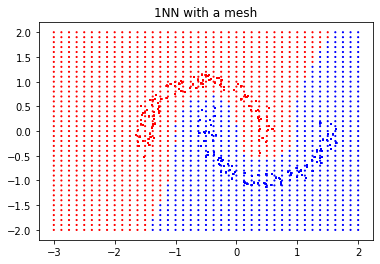

In [27]:

plt.figure()

col = df['Prediction'].map({0:'b', 1:'r'})
plt.scatter(df['x0'], df['x1'], c=col, marker='+', s=5)

col = mesh['Prediction'].map({0:'b', 1:'r'})
plt.scatter(mesh['x0'], mesh['x1'], c=col, marker='.', s=5)

plt.title('1NN with a mesh')
plt.savefig('images/Q1.png')
plt.show();

# Q2

In [6]:
df = pd.read_csv('data/emails.csv')
df = df.iloc[:,1:]

In [7]:
def k_fold_validation_sets(df, k_fold=5):
    """
    df: dataset to do k folds. Assumes the index is ordered
    
    tuple: (test indexes, train indexes)
    """

    size = int(df.shape[0]/k_fold)
    # print(size)
    test_indexes = []
    train_indexes = []
    for from_ in range(0, df.shape[0], size):
        to_ = from_+size
        test_index = df[from_:to_].index
        train_index = list(df[:from_].index) + list(df[to_:].index)
        test_indexes.append(test_index)
        train_indexes.append(train_index)
    return test_indexes, train_indexes


In [8]:
def print_scores(y, pred):  
    """
    Prints accuracy, precision and recall
    Assumes y and pred have labels 0 or 1
    
    y: np.array of test data
    pred: np.array of prediction
    """
    TP = ((y == 1) & (pred == 1)).sum()
    TN = ((y == 0) & (pred == 0)).sum()
    FN = ((y == 1) & (pred == 0)).sum()
    FP = ((y == 0) & (pred == 1)).sum()

    acc = (TP+TN)/len(pred)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)

    print('accuracy:', acc)
    print('precision:', precision)
    print('recall:', recall)

In [9]:
k_fold = 5
test_indexes, train_indexes = k_fold_validation_sets(df, k_fold=k_fold)

In [10]:
for i in range(k_fold):
    train = df.loc[train_indexes[i]]
    test = df.loc[test_indexes[i]]

    pred = knn_predict(train, test.iloc[:, :-1], k=1)
    print('fold:', i)
    print_scores(test['Prediction'], pred)
    print()

fold: 0
accuracy: 0.825
precision: 0.6544943820224719
recall: 0.8175438596491228

fold: 1
accuracy: 0.853
precision: 0.6857142857142857
recall: 0.8664259927797834

fold: 2
accuracy: 0.862
precision: 0.7212121212121212
recall: 0.8380281690140845

fold: 3
accuracy: 0.851
precision: 0.7164179104477612
recall: 0.8163265306122449

fold: 4
accuracy: 0.775
precision: 0.6057441253263708
recall: 0.7581699346405228



In [11]:
# sklearn implementation

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=5)
# kf.get_n_splits(df)

# for i, (train_index, test_index) in enumerate(kf.split(df)):
# #     print(f"  Train: index={train_index}")
# #     print(f"  Test:  index={test_index}")
        
#     train = df.loc[train_indexes[i]]
#     test = df.loc[test_indexes[i]]
    
#     neigh = KNeighborsClassifier(n_neighbors=1)
#     neigh.fit(train.iloc[:, :-1], train['Prediction'])

#     pred = neigh.predict(test.iloc[:, :-1])

#     print('fold:', i)
#     print_scores(test['Prediction'], pred)
#     print()

# Q3

In [12]:
def sigmoid_func(theta, X):
    """
    theta: np.array of weights
    X: data frame
    
    np.array through the sigmoid funciton
    """
        return 1/(1+np.exp(- X @ theta))

def train_logistic_regresion(X, y, learning_rate=0.0001, iterations=10):
    """
    X: data frame of training data
    y: np.array of training labels
    
    theta: np.array weights (including origin intercept)
    """
    n = X.shape[0]

    X[0] = 1
    theta = np.zeros(X.shape[1])

    for i in range(iterations):
        pred = sigmoid_func(theta, X)
#         print(((pred > 0.5)==y).mean()) # accuracy while training
        theta -= learning_rate * 1/n * (X.T @ (pred  - y))
   
    return theta
def predict_logistic_regresion(theta, X):
    proba = sigmoid_func(theta, X)
    return (proba >= 0.5)*1

In [13]:
test_indexes, train_indexes = k_fold_validation_sets(df, k_fold=5)

for i in range(5):
    train = df.loc[train_indexes[i]]
    test = df.loc[test_indexes[i]]

    X = train.iloc[:, :-1]
    y = train.iloc[:, -1]
    X_test = test.iloc[:, :-1]
    X_test[0] = 1
    y_test = test.iloc[:, -1]
    
    print('\nk fold:', i)
    theta = train_logistic_regresion(X, y, 0.0005, 1000)
#     print('score on train\n')
#     pred = predict_logistic_regresion(theta, X)
#     print_scores(y, pred)
    print('score on test')
    pred = predict_logistic_regresion(theta, X_test)
    print_scores(y_test, pred)



k fold: 0
score on test
accuracy: 0.896
precision: 0.8549019607843137
recall: 0.7649122807017544

k fold: 1
score on test
accuracy: 0.894
precision: 0.8489795918367347
recall: 0.7509025270758123

k fold: 2
score on test
accuracy: 0.871
precision: 0.9015544041450777
recall: 0.6126760563380281

k fold: 3
score on test
accuracy: 0.864
precision: 0.8526785714285714
recall: 0.6496598639455783

k fold: 4
score on test
accuracy: 0.83
precision: 0.7741935483870968
recall: 0.6274509803921569


# Q4

In [14]:
kneighbors = [1, 3, 5, 7, 10]
mean_accs = []
for k in tqdm(kneighbors):
    accs = []
    for i in range(k_fold):
        train = df.loc[train_indexes[i]]
        test = df.loc[test_indexes[i]]

        pred = knn_predict(train, test.iloc[:, :-1], k=k)
        acc = (test['Prediction'] == pred).mean()
        accs.append(acc)
    mean_acc = np.mean(accs)
    mean_accs.append(mean_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

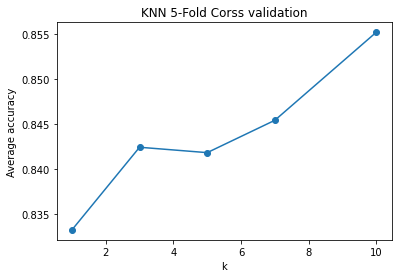

In [19]:
plt.figure()
plt.plot(kneighbors, mean_accs, marker='o')
plt.ylabel('Average accuracy')
plt.xlabel('k')
plt.title('KNN 5-Fold Corss validation')
plt.savefig('images/Q4.png')
plt.show();

In [20]:
mean_accs

[0.8332, 0.8423999999999999, 0.8417999999999999, 0.8454, 0.8552]

# Q5

In [16]:
i = 1

train = df.loc[train_indexes[i]]
test = df.loc[test_indexes[i]]

X = train.iloc[:, :-1]
y = train.iloc[:, -1]
X_test = test.iloc[:, :-1]
X_test[0] = 1
y_test = test.iloc[:, -1]

proba_knn = knn_predict(train, test, k=5, return_proba=True)

theta = train_logistic_regresion(X, y, 0.0005, 1000)
proba_lr = sigmoid_func(theta, X_test)

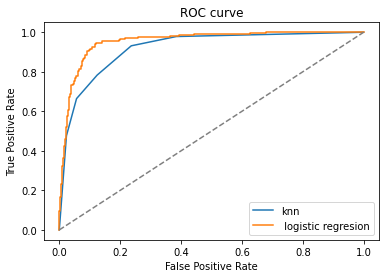

In [17]:
plt.figure()

fpr, tpr, thresholds = metrics.roc_curve(y_test, proba_knn)
plt.plot(fpr, tpr, label = 'knn')

fpr, tpr, thresholds = metrics.roc_curve(y_test, proba_lr)
plt.plot(fpr, tpr, label =' logistic regresion')

plt.plot([0, 1], [0, 1], '--', c='grey')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig('images/Q5.png')
plt.show();